In [ ]:

import spacy
import matplotlib.pyplot as plt
from rapidfuzz import process, fuzz
from rake_nltk import Rake
import re
import pandas as pd


nlp = spacy.load("en_core_web_sm")
r = Rake(min_length=2, max_length=5)  # only keep phrases with 2–5 words

In [34]:
df=pd.read_csv("task2.csv")
df.head(3)

,Event id,Opened date,CAUSAL_VERBATIM,CORRECTION_VERBATIM,CUSTOMER_VERBATIM,BUILD_DATE,BUILD_PLANT_DESC,CAUSAL_CD_DESC,COMPLAINT_CD_DESC,IN_USE_DATE,MAKE,MODEL,MODLYR,PLANT,Trigger,Failure Component,Failure Condition,Additional Context,Fix Component,Fix Condition
0,D-14801,9/17/2019,unable to duplicate the concern at this time r...,"waiting for techline engineering response, att...",Customer reports that radio and screen is inte...,2019-08-14T00:00:00.000Z,Flint,Module/Component-No/Incorrect Communication,Audio/Entertainment/Navigation - Other issues,2019-09-10T00:00:00.000Z,NovaSprint,AeroSpecter,2020,FLT,['No Additional Functionality'],"['Audio Unit', 'Display']","['Controls Irresponsive', 'Black Screen']",['No Additional Context'],"['Radio', 'SPS']","['Replaced', 'Programmed']"
1,D-14869,7/6/2020,upon inspection radio screen was found to be b...,and ground at radio as stated in service info ...,RADIO IS INOPERABLE CHECK AND ADVISE,2019-08-16T00:00:00.000Z,Fort Wayne,Module/Component-Shorted,Audio/Entertainment/Navigation - Other issues,2020-03-26T00:00:00.000Z,NebulaCruiser,StellarGlide,2020,FTW,['No Additional Functionality'],"['Radio', 'Display', 'Radio']","['Inoperative', 'Black Screen', 'No Sound']",['No Additional Context'],"['Radio', 'USB']","['Replaced', 'Programmed']"
2,D-14555,1/9/2020,Scanned found no codes checked for bulletins f...,radio module internal failure,CUSTOMER STATES RADIO SCREEN AND ONSTAR KEEPS ...,2019-08-06T00:00:00.000Z,Flint,Module/Component-Worn/Stripped,Audio/Entertainment/Navigation - Other issues,2019-11-29T00:00:00.000Z,ThunderVolt,HyperFury X,2020,FLT,['No Additional Functionality'],"['Display', 'OnStar', 'Radio Module']","['Inoperative', 'Inoperative', 'Internal Fault']",['No Additional Context'],['Radio'],['Replaced']


In [35]:
#Changing Date columns to actual date time objects

date_columns=["Opened date", "BUILD_DATE","IN_USE_DATE" ]

for cols in date_columns:
    df[cols]=pd.to_datetime(df[cols],format='mixed')
    df[cols]=df[cols].dt.date

In [36]:
df.head(1).T

,0
Event id,D-14801
Opened date,2019-09-17
CAUSAL_VERBATIM,unable to duplicate the concern at this time r...
CORRECTION_VERBATIM,"waiting for techline engineering response, att..."
CUSTOMER_VERBATIM,Customer reports that radio and screen is inte...
BUILD_DATE,2019-08-14
BUILD_PLANT_DESC,Flint
CAUSAL_CD_DESC,Module/Component-No/Incorrect Communication
COMPLAINT_CD_DESC,Audio/Entertainment/Navigation - Other issues
IN_USE_DATE,2019-09-10


In [37]:
df.columns

Index(['Event id', 'Opened date', 'CAUSAL_VERBATIM', 'CORRECTION_VERBATIM',
       'CUSTOMER_VERBATIM', 'BUILD_DATE', 'BUILD_PLANT_DESC', 'CAUSAL_CD_DESC',
       'COMPLAINT_CD_DESC', 'IN_USE_DATE', 'MAKE', 'MODEL', 'MODLYR', 'PLANT',
       'Trigger', 'Failure Component', 'Failure Condition',
       'Additional Context', 'Fix Component', 'Fix Condition'],
      dtype='object')

In [38]:
df.drop_duplicates()

,Event id,Opened date,CAUSAL_VERBATIM,CORRECTION_VERBATIM,CUSTOMER_VERBATIM,BUILD_DATE,BUILD_PLANT_DESC,CAUSAL_CD_DESC,COMPLAINT_CD_DESC,IN_USE_DATE,MAKE,MODEL,MODLYR,PLANT,Trigger,Failure Component,Failure Condition,Additional Context,Fix Component,Fix Condition
0,D-14801,2019-09-17,unable to duplicate the concern at this time r...,"waiting for techline engineering response, att...",Customer reports that radio and screen is inte...,2019-08-14,Flint,Module/Component-No/Incorrect Communication,Audio/Entertainment/Navigation - Other issues,2019-09-10,NovaSprint,AeroSpecter,2020,FLT,['No Additional Functionality'],"['Audio Unit', 'Display']","['Controls Irresponsive', 'Black Screen']",['No Additional Context'],"['Radio', 'SPS']","['Replaced', 'Programmed']"
1,D-14869,2020-07-06,upon inspection radio screen was found to be b...,and ground at radio as stated in service info ...,RADIO IS INOPERABLE CHECK AND ADVISE,2019-08-16,Fort Wayne,Module/Component-Shorted,Audio/Entertainment/Navigation - Other issues,2020-03-26,NebulaCruiser,StellarGlide,2020,FTW,['No Additional Functionality'],"['Radio', 'Display', 'Radio']","['Inoperative', 'Black Screen', 'No Sound']",['No Additional Context'],"['Radio', 'USB']","['Replaced', 'Programmed']"
2,D-14555,2020-01-09,Scanned found no codes checked for bulletins f...,radio module internal failure,CUSTOMER STATES RADIO SCREEN AND ONSTAR KEEPS ...,2019-08-06,Flint,Module/Component-Worn/Stripped,Audio/Entertainment/Navigation - Other issues,2019-11-29,ThunderVolt,HyperFury X,2020,FLT,['No Additional Functionality'],"['Display', 'OnStar', 'Radio Module']","['Inoperative', 'Inoperative', 'Internal Fault']",['No Additional Context'],['Radio'],['Replaced']
3,D-14704,2020-04-14,"PANTALLA SE PONE NEGRA, LO QUE PROVOCA QUE AL ...",DESPUES DE REALIZAR LA INPECCION VISUAL Y OPER...,PANTALLA SE PONE NEGRA,2019-08-12,Spring Hill - Truck,Module/Component-No/Incorrect Communication,Features/Controls/Displays - Other issues,2019-12-26,ThunderVolt,HyperFury X,2020,SHT,['When Reversing'],['Display'],['Black Screen'],['While Driving'],"['Radio', 'USB']","['Replaced', 'Programmed']"
4,D-15142,2020-11-23,INSPECTED VEHICLE AND CONFIRMED THAT THE...,SCRANNED FOR CODES NONE FOUND FOUND UPDATE N...,CUSTOMER STATES A MESSAGE OF LOST SATELITE SIG...,2019-08-27,Fort Wayne,Module/Component-Registers Incorrectly,Audio/Entertainment/Navigation - Other issues,2019-10-31,ThunderVolt,TurboFlare,2020,FTW,['No Additional Functionality'],['Radio'],['Malfunction'],['No Additional Context'],['Radio'],['Replaced']
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,D-14576,2020-09-03,internal radio short,replaced radio,radio screen goes blank,2019-08-07,Fort Wayne,Module/Component-Registers Incorrectly,Audio/Entertainment/Navigation - Other issues,2019-09-04,ThunderVolt,TurboFlare,2020,FTW,NaN,NaN,NaN,NaN,NaN,NaN
996,D-15355,2020-04-02,iNTERNAL FAULT IN RADIO,REPLACED RADIO,RADIO WON'T LIGHT UP,2019-09-04,Silao,Module/Component-Shorted,Audio/Entertainment/Navigation - Audio,2020-05-27,ThunderVolt,WarpDriveX,2020,SIL,NaN,NaN,NaN,NaN,NaN,NaN
997,D-15322,2021-03-22,FOUJND RADIO INERNAL SHORT,REPLACE RADIO,CAMERA FREEZING UP,2019-09-03,Flint,Module/Component-Registers Incorrectly,Audio/Entertainment/Navigation - Audio,2019-09-28,NebulaCruiser,StellarGlide,2020,FLT,NaN,NaN,NaN,NaN,NaN,NaN
998,D-14741,2019-10-11,INTERNAL FAILURE IN RADIO,REPLACE RADIO,BLANK RADIO SREEN,2019-08-13,Fort Wayne,Module/Component-Shorted,Audio/Entertainment/Navigation - Video,2019-09-28,ThunderVolt,ZenithCruiser,2020,FTW,NaN,NaN,NaN,NaN,NaN,NaN


In [39]:
# Free text columns are usually of object dtype and have longer text entries
free_text_cols = [col for col in df.columns if df[col].dtype == "object" and df[col].astype(str).str.len().mean() > 15]

print("Identified free text columns:", free_text_cols)


Identified free text columns: ['CAUSAL_VERBATIM', 'CORRECTION_VERBATIM', 'CUSTOMER_VERBATIM', 'CAUSAL_CD_DESC', 'COMPLAINT_CD_DESC']


In [40]:
# By mannual observation found some of the common keywords through the dataset and extracted some more related keywords from internet
seed_components = [
    "radio", "head unit", "display", "screen", "speaker", "usb port", "amplifier",
    "antenna", "bcm", "ecu", "module", "onstar", "wiring harness", "camera", "gps",
    "nav", "microphone", "button", "knob"
]

seed_conditions = [
    "black screen", "no sound", "inoperative", "intermittent", "shorted",
    "no communication", "reboot", "frozen", "static", "error code",
    "bluetooth issue", "pairing failure"
]

seed_fix_conditions = [
    "replaced", "installed", "programmed", "updated", "calibrated",
    "reflashed", "secured", "cleaned", "rerouted", "software update"

]

r=Rake()

In [41]:
# Clean text: lowercase, remove special chars
def clean_text(text):
    if pd.isna(text):
        return ""
    text = str(text).lower()
    text = re.sub(r"[^a-z0-9\s]", " ", text)  # keep alphanumeric
    text = re.sub(r"\s+", " ", text).strip()
    return text

# Fuzzy match with score
def fuzzy_match_all(text_list, seed_list, score_cutoff=80):
    matches = []
    for phrase in text_list:
        result = process.extractOne(phrase, seed_list, scorer=fuzz.token_sort_ratio, score_cutoff=score_cutoff)
        if result:
            match, score, _ = result
            matches.append((match, score))
    return matches if matches else None

# RAKE keyword extraction
def extract_rake_phrases(text):
    r.extract_keywords_from_text(text)
    return r.get_ranked_phrases()

# Combine RAKE + noun chunks
def get_candidate_phrases(text):
    rake_phrases = extract_rake_phrases(text)
    doc = nlp(text)
    noun_chunks = [chunk.text.lower() for chunk in doc.noun_chunks]
    return list(set(rake_phrases + noun_chunks))


In [42]:
# Combine free text into one field


df["combined_text"] = df[free_text_cols].fillna("").agg(" ".join, axis=1).apply(clean_text)

results = []

for _, row in df.iterrows():
    text = row["combined_text"]
    if not text:
        results.append({
            "Failure Components": [],
            "Failure Conditions": [],
            "Fix Conditions": [],
            "Issue Type": ["Uncategorized"],
            "Match Details": {}
        })
        continue

    candidates = get_candidate_phrases(text)

    # Match all possible seeds (with scores)
    matched_components = fuzzy_match_all(candidates, seed_components)
    matched_conditions = fuzzy_match_all(candidates, seed_conditions)
    matched_fixes = fuzzy_match_all(candidates, seed_fix_conditions)

    # Dynamic classification rules
    issue_type = []
    if matched_components and matched_conditions:
        issue_type.append("Component Failure")
    if matched_conditions and any(m[0] in ["shorted", "no communication"] for m in matched_conditions):
        issue_type.append("Electrical Issue")
    if matched_fixes and any(m[0] in ["programmed", "updated", "calibrated", "reflashed", "software update"] for m in matched_fixes):
        issue_type.append("Software/Calibration")
    if not issue_type:
        issue_type.append("Uncategorized")

    results.append({
        "Failure Components": [m[0] for m in matched_components] if matched_components else [],
        "Failure Conditions": [m[0] for m in matched_conditions] if matched_conditions else [],
        "Fix Conditions": [m[0] for m in matched_fixes] if matched_fixes else [],
        "Issue Type": list(set(issue_type)),

    })


In [43]:
# Convert results to DataFrame
extracted_df = pd.DataFrame(results)

# Merge with original data
final_df = pd.concat([df, extracted_df], axis=1)
final_df=final_df.drop(['Trigger', 'Failure Component', 'Failure Condition',
       'Additional Context', 'Fix Component', 'Fix Condition'],axis=1)

# Save structured output
final_df.to_csv("Final_structured_output.csv", index=False)

final_df.head()





,Event id,Opened date,CAUSAL_VERBATIM,CORRECTION_VERBATIM,CUSTOMER_VERBATIM,BUILD_DATE,BUILD_PLANT_DESC,CAUSAL_CD_DESC,COMPLAINT_CD_DESC,IN_USE_DATE,MAKE,MODEL,MODLYR,PLANT,combined_text,Failure Components,Failure Conditions,Fix Conditions,Issue Type
0,D-14801,2019-09-17,unable to duplicate the concern at this time r...,"waiting for techline engineering response, att...",Customer reports that radio and screen is inte...,2019-08-14,Flint,Module/Component-No/Incorrect Communication,Audio/Entertainment/Navigation - Other issues,2019-09-10,NovaSprint,AeroSpecter,2020,FLT,unable to duplicate the concern at this time r...,"[display, screen, radio, amplifier, amplifier,...",[black screen],"[programmed, software update, replaced, progra...","[Component Failure, Software/Calibration]"
1,D-14869,2020-07-06,upon inspection radio screen was found to be b...,and ground at radio as stated in service info ...,RADIO IS INOPERABLE CHECK AND ADVISE,2019-08-16,Fort Wayne,Module/Component-Shorted,Audio/Entertainment/Navigation - Other issues,2020-03-26,NebulaCruiser,StellarGlide,2020,FTW,upon inspection radio screen was found to be b...,"[module, module, bcm, radio, module, screen]",[no sound],[replaced],[Component Failure]
2,D-14555,2020-01-09,Scanned found no codes checked for bulletins f...,radio module internal failure,CUSTOMER STATES RADIO SCREEN AND ONSTAR KEEPS ...,2019-08-06,Flint,Module/Component-Worn/Stripped,Audio/Entertainment/Navigation - Other issues,2019-11-29,ThunderVolt,HyperFury X,2020,FLT,scanned found no codes checked for bulletins f...,"[radio, onstar]",[],[updated],[Software/Calibration]
3,D-14704,2020-04-14,"PANTALLA SE PONE NEGRA, LO QUE PROVOCA QUE AL ...",DESPUES DE REALIZAR LA INPECCION VISUAL Y OPER...,PANTALLA SE PONE NEGRA,2019-08-12,Spring Hill - Truck,Module/Component-No/Incorrect Communication,Features/Controls/Displays - Other issues,2019-12-26,ThunderVolt,HyperFury X,2020,SHT,pantalla se pone negra lo que provoca que al p...,[display],[],[],[Uncategorized]
4,D-15142,2020-11-23,INSPECTED VEHICLE AND CONFIRMED THAT THE...,SCRANNED FOR CODES NONE FOUND FOUND UPDATE N...,CUSTOMER STATES A MESSAGE OF LOST SATELITE SIG...,2019-08-27,Fort Wayne,Module/Component-Registers Incorrectly,Audio/Entertainment/Navigation - Other issues,2019-10-31,ThunderVolt,TurboFlare,2020,FTW,inspected vehicle and confirmed that the displ...,[antenna],[no communication],[updated],"[Component Failure, Electrical Issue, Software..."


In [44]:
final_df

,Event id,Opened date,CAUSAL_VERBATIM,CORRECTION_VERBATIM,CUSTOMER_VERBATIM,BUILD_DATE,BUILD_PLANT_DESC,CAUSAL_CD_DESC,COMPLAINT_CD_DESC,IN_USE_DATE,MAKE,MODEL,MODLYR,PLANT,combined_text,Failure Components,Failure Conditions,Fix Conditions,Issue Type
0,D-14801,2019-09-17,unable to duplicate the concern at this time r...,"waiting for techline engineering response, att...",Customer reports that radio and screen is inte...,2019-08-14,Flint,Module/Component-No/Incorrect Communication,Audio/Entertainment/Navigation - Other issues,2019-09-10,NovaSprint,AeroSpecter,2020,FLT,unable to duplicate the concern at this time r...,"[display, screen, radio, amplifier, amplifier,...",[black screen],"[programmed, software update, replaced, progra...","[Component Failure, Software/Calibration]"
1,D-14869,2020-07-06,upon inspection radio screen was found to be b...,and ground at radio as stated in service info ...,RADIO IS INOPERABLE CHECK AND ADVISE,2019-08-16,Fort Wayne,Module/Component-Shorted,Audio/Entertainment/Navigation - Other issues,2020-03-26,NebulaCruiser,StellarGlide,2020,FTW,upon inspection radio screen was found to be b...,"[module, module, bcm, radio, module, screen]",[no sound],[replaced],[Component Failure]
2,D-14555,2020-01-09,Scanned found no codes checked for bulletins f...,radio module internal failure,CUSTOMER STATES RADIO SCREEN AND ONSTAR KEEPS ...,2019-08-06,Flint,Module/Component-Worn/Stripped,Audio/Entertainment/Navigation - Other issues,2019-11-29,ThunderVolt,HyperFury X,2020,FLT,scanned found no codes checked for bulletins f...,"[radio, onstar]",[],[updated],[Software/Calibration]
3,D-14704,2020-04-14,"PANTALLA SE PONE NEGRA, LO QUE PROVOCA QUE AL ...",DESPUES DE REALIZAR LA INPECCION VISUAL Y OPER...,PANTALLA SE PONE NEGRA,2019-08-12,Spring Hill - Truck,Module/Component-No/Incorrect Communication,Features/Controls/Displays - Other issues,2019-12-26,ThunderVolt,HyperFury X,2020,SHT,pantalla se pone negra lo que provoca que al p...,[display],[],[],[Uncategorized]
4,D-15142,2020-11-23,INSPECTED VEHICLE AND CONFIRMED THAT THE...,SCRANNED FOR CODES NONE FOUND FOUND UPDATE N...,CUSTOMER STATES A MESSAGE OF LOST SATELITE SIG...,2019-08-27,Fort Wayne,Module/Component-Registers Incorrectly,Audio/Entertainment/Navigation - Other issues,2019-10-31,ThunderVolt,TurboFlare,2020,FTW,inspected vehicle and confirmed that the displ...,[antenna],[no communication],[updated],"[Component Failure, Electrical Issue, Software..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,D-14576,2020-09-03,internal radio short,replaced radio,radio screen goes blank,2019-08-07,Fort Wayne,Module/Component-Registers Incorrectly,Audio/Entertainment/Navigation - Other issues,2019-09-04,ThunderVolt,TurboFlare,2020,FTW,internal radio short replaced radio radio scre...,[],[],[],[Uncategorized]
996,D-15355,2020-04-02,iNTERNAL FAULT IN RADIO,REPLACED RADIO,RADIO WON'T LIGHT UP,2019-09-04,Silao,Module/Component-Shorted,Audio/Entertainment/Navigation - Audio,2020-05-27,ThunderVolt,WarpDriveX,2020,SIL,internal fault in radio replaced radio radio w...,[],[],[],[Uncategorized]
997,D-15322,2021-03-22,FOUJND RADIO INERNAL SHORT,REPLACE RADIO,CAMERA FREEZING UP,2019-09-03,Flint,Module/Component-Registers Incorrectly,Audio/Entertainment/Navigation - Audio,2019-09-28,NebulaCruiser,StellarGlide,2020,FLT,foujnd radio inernal short replace radio camer...,[],[],[],[Uncategorized]
998,D-14741,2019-10-11,INTERNAL FAILURE IN RADIO,REPLACE RADIO,BLANK RADIO SREEN,2019-08-13,Fort Wayne,Module/Component-Shorted,Audio/Entertainment/Navigation - Video,2019-09-28,ThunderVolt,ZenithCruiser,2020,FTW,internal failure in radio replace radio blank ...,[],[],[],[Uncategorized]


## Insights within the data

In [45]:
from collections import Counter


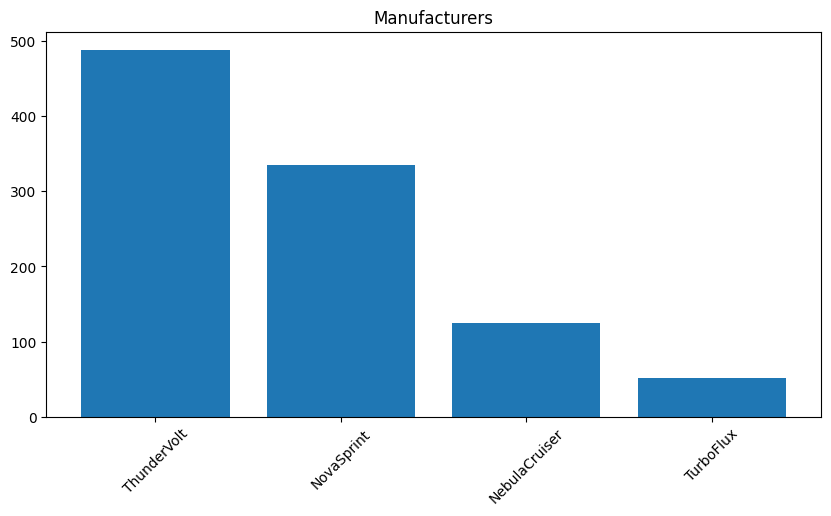

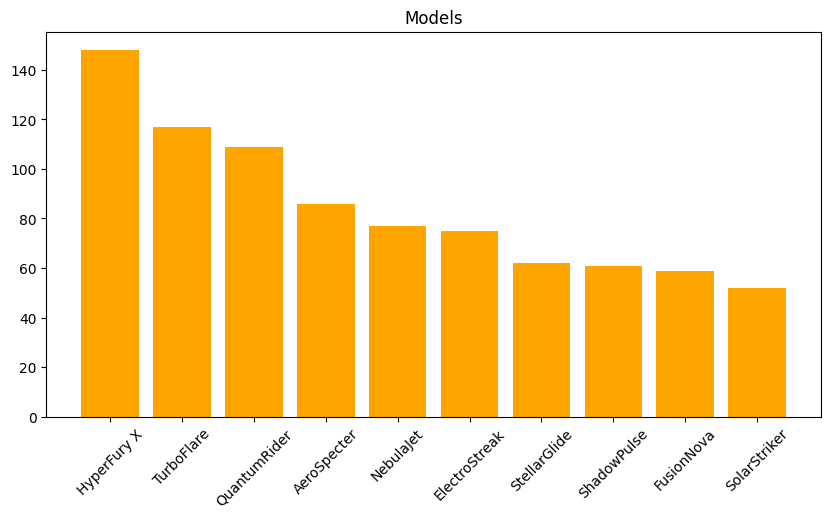

In [46]:
# Count the models, manufactures

manufacture_counts=Counter(final_df["MAKE"])
model_counts=Counter(final_df["MODEL"])

manufacture_df=pd.DataFrame(manufacture_counts.most_common(10), columns=["manufacturer", "Count"])
model_df=pd.DataFrame(model_counts.most_common(10), columns=["model", "Count"])

#plot
plt.figure(figsize=(10,5))
plt.bar(manufacture_df["manufacturer"], manufacture_df["Count"])
plt.xticks(rotation=45)
plt.title("Manufacturers")
plt.show()

plt.figure(figsize=(10,5))
plt.bar(model_df["model"], model_df["Count"], color="orange")
plt.xticks(rotation=45)
plt.title("Models")
plt.show()

In [47]:
# Count most common failures, conditions, and fixes
# Flatten all lists before counting
component_counts=Counter([comp for row in results for comp in row["Failure Components"]])
condition_counts=Counter([cond for row in results for cond in row["Failure Conditions"]])
fix_counts=Counter([fix for row in results for fix in row["Fix Conditions"]])



print("Top 10 Failure Components:")
print(component_counts.most_common(10))

print("\nTop 10 Failure Conditions:")
print(condition_counts.most_common(10))

print("\nTop 10 Fix Conditions:")
print(fix_counts.most_common(10))


# Convert to DataFrame for plotting
comp_df=pd.DataFrame(component_counts.most_common(10), columns=["Component", "Count"])
cond_df=pd.DataFrame(condition_counts.most_common(10), columns=["Condition", "Count"])
fix_df=pd.DataFrame(fix_counts.most_common(10),columns=["fixes","count"])



Top 10 Failure Components:
[('radio', 679), ('display', 87), ('camera', 75), ('screen', 68), ('module', 26), ('onstar', 23), ('nav', 15), ('antenna', 14), ('amplifier', 11), ('button', 8)]

Top 10 Failure Conditions:
[('no communication', 167), ('no sound', 51), ('black screen', 37), ('intermittent', 30), ('error code', 18), ('shorted', 13), ('inoperative', 7), ('bluetooth issue', 4), ('frozen', 4), ('reboot', 3)]

Top 10 Fix Conditions:
[('programmed', 140), ('replaced', 100), ('updated', 60), ('software update', 28), ('installed', 15), ('cleaned', 5), ('secured', 1), ('rerouted', 1), ('calibrated', 1)]


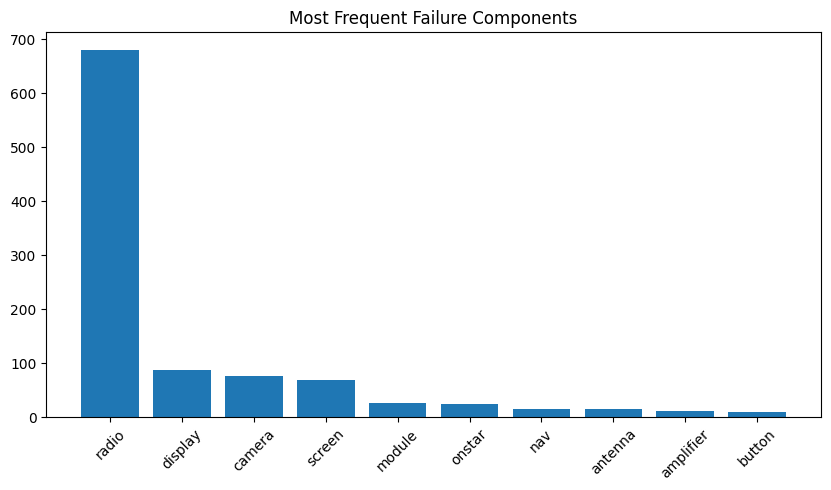

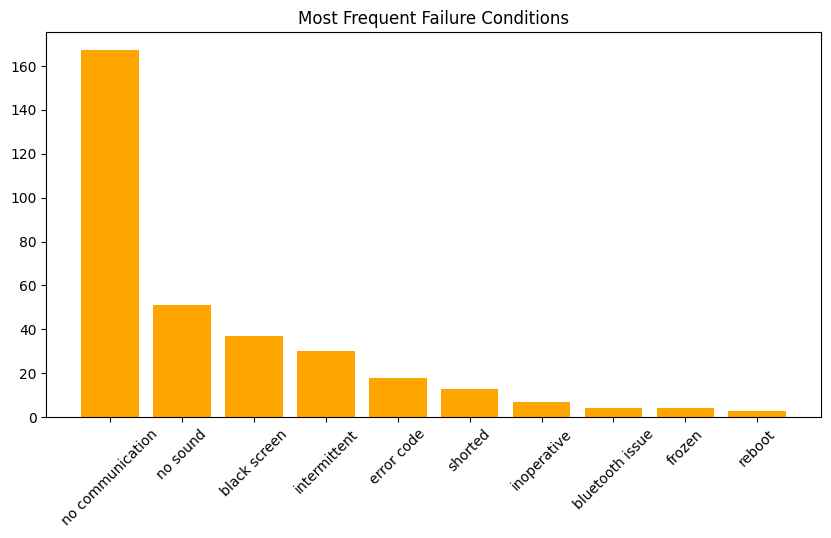

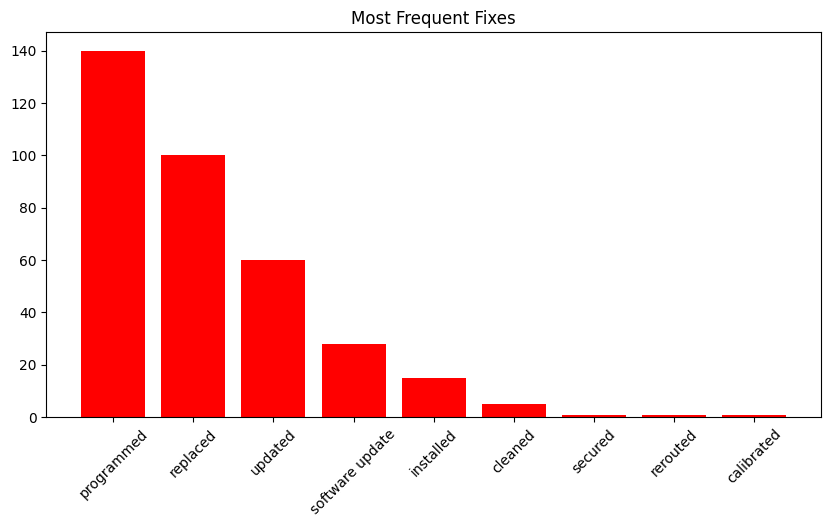

In [48]:
# Plot
plt.figure(figsize=(10,5))
plt.bar(comp_df["Component"], comp_df["Count"])
plt.xticks(rotation=45)
plt.title("Most Frequent Failure Components")
plt.show()

plt.figure(figsize=(10,5))
plt.bar(cond_df["Condition"], cond_df["Count"], color="orange")
plt.xticks(rotation=45)
plt.title("Most Frequent Failure Conditions")
plt.show()

plt.figure(figsize=(10,5))
plt.bar(fix_df["fixes"], fix_df["count"], color="red")
plt.xticks(rotation=45)
plt.title("Most Frequent Fixes")
plt.show()

